In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import odeint
from math import pi
from pysindy.differentiation import FiniteDifference
fd = FiniteDifference(order=2, d=1)

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import glob
from sklearn.metrics import mean_absolute_error

In [62]:
import pandas as pd

df = pd.read_csv (r'hysteresis_v_150_1hz.csv')
print (df)


       Unnamed: 0        0  -1.6174316        0.1
0             NaN   0.0002   -1.724243    0.00000
1             NaN   0.0004   -1.655579    0.00000
2             NaN   0.0006   -1.754761    0.00000
3             NaN   0.0008   -1.701355    0.00000
4             NaN   0.0010   -1.701355    0.00000
...           ...      ...         ...        ...
49995         NaN   9.9992  -13.984680 -117.59304
49996         NaN   9.9994  -13.916016 -117.70996
49997         NaN   9.9996  -13.931274 -117.82671
49998         NaN   9.9998  -13.839722 -117.94326
49999         NaN  10.0000  -13.938904 -118.05964

[50000 rows x 4 columns]


In [63]:
df.shape

(50000, 4)

In [64]:
data = df.to_numpy()
data.shape

(50000, 4)

In [65]:
data_col = data[:,1:4]

In [66]:
data_final = data_col[35000:45000,:]

In [67]:
data_final.shape

(10000, 3)

In [68]:
t = data_final[:,0]
t.shape

(10000,)

In [69]:
x = data_final[:,2]
x.shape

(10000,)

In [70]:
y = data_final[:,1]
#y = y.reshape(-1,1)
y.shape

(10000,)

In [71]:
dx = fd._differentiate(x, t)

In [72]:
dy = -0.993*y + 0.237*x + 0.126*dx

In [61]:
t.shape

(10000,)

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"
# Random Seed for dataset generation
sampling_seed = 78
torch.manual_seed(sampling_seed)

# Number of training samples
n_samples = 10000

t = t.reshape(-1,1)
y = y.reshape(-1,1)

t = t.astype(np.float32)
y = y.astype(np.float32)

t = torch.from_numpy(t)
y = torch.from_numpy(y)

batch_size = n_samples
training_set = DataLoader(torch.utils.data.TensorDataset(t, y), batch_size=batch_size, shuffle=True)

In [15]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)

def NeuralNet_Seq(input_dimension, output_dimension, n_hidden_layers, neurons):
    modules = list()
    modules.append(nn.Linear(input_dimension, neurons))
    modules.append(nn.Tanh())
    for _ in range(n_hidden_layers):
        modules.append(nn.Linear(neurons, neurons))
        modules.append(nn.Tanh())
    modules.append(nn.Linear(neurons, output_dimension))
    model =  nn.Sequential(*modules)
    return model

  


In [16]:
# Model definition
my_network = NeuralNet(input_dimension=t.shape[1], output_dimension=y.shape[1]+1, n_hidden_layers=4, neurons=20)
# my_network = NeuralNet_Seq(input_dimension=x.shape[1], output_dimension=y.shape[1], n_hidden_layers=4, neurons=20)

In [17]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
# Model definition

# Predict network value of x
print(my_network(t))

tensor([[0.1257, 1.4301],
        [0.1257, 1.4301],
        [0.1257, 1.4301],
        ...,
        [0.1789, 1.4346],
        [0.1789, 1.4346],
        [0.1789, 1.4346]], grad_fn=<AddmmBackward0>)


In [18]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [19]:
def fit(model, training_set, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (x_train_, u_train_) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                
                x_train_.requires_grad = True
                
                u_pred_tot = model(x_train_)
                u_pred_ = u_pred_tot[:, 0]
                deriv_pred_ = u_pred_tot[:, 1]
                
                inputs = torch.ones(10000, 1 )
                grad_u_hat = torch.autograd.grad(u_pred_.reshape(-1,1), x_train_, grad_outputs=inputs, create_graph=True)[0]
                
                u_x = grad_u_hat[:, 0].reshape(-1,1)
                
                # Item 1. below
                loss = torch.mean((u_pred_.reshape(-1, ) - u_train_.reshape(-1, ))**p)
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [20]:
n_epochs = 5000
history = fit(my_network, training_set, n_epochs, optimizer_, p=2, verbose=True )

################################  0  ################################
Loss:  191.56346130371094
################################  1  ################################
Loss:  191.5428009033203
################################  2  ################################
Loss:  191.5252227783203
################################  3  ################################
Loss:  191.49803161621094
################################  4  ################################
Loss:  191.45941162109375
################################  5  ################################
Loss:  191.41436767578125
################################  6  ################################
Loss:  191.37478637695312
################################  7  ################################
Loss:  191.343994140625
################################  8  ################################
Loss:  191.31707763671875
################################  9  ################################
Loss:  191.2893524169922
################################  10  #######

Loss:  148.19921875
################################  87  ################################
Loss:  147.24368286132812
################################  88  ################################
Loss:  146.3143310546875
################################  89  ################################
Loss:  145.51231384277344
################################  90  ################################
Loss:  144.7498321533203
################################  91  ################################
Loss:  144.1849365234375
################################  92  ################################
Loss:  143.63348388671875
################################  93  ################################
Loss:  143.14877319335938
################################  94  ################################
Loss:  142.64883422851562
################################  95  ################################
Loss:  142.20016479492188
################################  96  ################################
Loss:  141.74200439453125
#############

Loss:  645738.125
################################  174  ################################
Loss:  488499.75
################################  175  ################################
Loss:  368693.5625
################################  176  ################################
Loss:  319061.15625
################################  177  ################################
Loss:  165278.40625
################################  178  ################################
Loss:  129303.71875
################################  179  ################################
Loss:  34706.109375
################################  180  ################################
Loss:  30971.677734375
################################  181  ################################
Loss:  27862.435546875
################################  182  ################################
Loss:  22982.830078125
################################  183  ################################
Loss:  19500.751953125
################################  184  ###############

Loss:  52.823699951171875
################################  260  ################################
Loss:  51.99294662475586
################################  261  ################################
Loss:  50.85764694213867
################################  262  ################################
Loss:  49.025840759277344
################################  263  ################################
Loss:  44.156150817871094
################################  264  ################################
Loss:  45.770572662353516
################################  265  ################################
Loss:  41.939971923828125
################################  266  ################################
Loss:  41.310245513916016
################################  267  ################################
Loss:  40.430198669433594
################################  268  ################################
Loss:  39.499595642089844
################################  269  ################################
Loss:  38.523189544677

Loss:  3.9166793823242188
################################  345  ################################
Loss:  3.861771583557129
################################  346  ################################
Loss:  3.808441400527954
################################  347  ################################
Loss:  3.7539546489715576
################################  348  ################################
Loss:  3.7028391361236572
################################  349  ################################
Loss:  3.650182008743286
################################  350  ################################
Loss:  3.5999441146850586
################################  351  ################################
Loss:  3.5457465648651123
################################  352  ################################
Loss:  3.4913249015808105
################################  353  ################################
Loss:  3.432030439376831
################################  354  ################################
Loss:  3.367959022521972

Loss:  0.9902582168579102
################################  430  ################################
Loss:  0.9833380579948425
################################  431  ################################
Loss:  0.9753677845001221
################################  432  ################################
Loss:  0.9655840992927551
################################  433  ################################
Loss:  0.9527468681335449
################################  434  ################################
Loss:  0.9374468922615051
################################  435  ################################
Loss:  0.9231566190719604
################################  436  ################################
Loss:  0.9130853414535522
################################  437  ################################
Loss:  0.904044508934021
################################  438  ################################
Loss:  0.8950891494750977
################################  439  ################################
Loss:  0.886275172233

Loss:  0.3875647485256195
################################  515  ################################
Loss:  0.3823014795780182
################################  516  ################################
Loss:  0.37691885232925415
################################  517  ################################
Loss:  0.3713465929031372
################################  518  ################################
Loss:  0.3656643331050873
################################  519  ################################
Loss:  0.35986292362213135
################################  520  ################################
Loss:  0.35413074493408203
################################  521  ################################
Loss:  0.3486280143260956
################################  522  ################################
Loss:  0.3436848819255829
################################  523  ################################
Loss:  0.33927643299102783
################################  524  ################################
Loss:  0.3356603

Loss:  0.21137085556983948
################################  599  ################################
Loss:  0.21037746965885162
################################  600  ################################
Loss:  0.2094568908214569
################################  601  ################################
Loss:  0.20857876539230347
################################  602  ################################
Loss:  0.2077735811471939
################################  603  ################################
Loss:  0.2070387452840805
################################  604  ################################
Loss:  0.20638063549995422
################################  605  ################################
Loss:  0.20577417314052582
################################  606  ################################
Loss:  0.20520664751529694
################################  607  ################################
Loss:  0.20467138290405273
################################  608  ################################
Loss:  0.2041

Loss:  0.1469936966896057
################################  683  ################################
Loss:  0.14628387987613678
################################  684  ################################
Loss:  0.14537101984024048
################################  685  ################################
Loss:  0.1443919539451599
################################  686  ################################
Loss:  0.14321604371070862
################################  687  ################################
Loss:  0.14206118881702423
################################  688  ################################
Loss:  0.14063730835914612
################################  689  ################################
Loss:  0.13895879685878754
################################  690  ################################
Loss:  0.13726748526096344
################################  691  ################################
Loss:  0.1354052871465683
################################  692  ################################
Loss:  0.1333

Loss:  0.06128532066941261
################################  767  ################################
Loss:  0.06115560233592987
################################  768  ################################
Loss:  0.06100253760814667
################################  769  ################################
Loss:  0.06088676676154137
################################  770  ################################
Loss:  0.06076422706246376
################################  771  ################################
Loss:  0.06061787158250809
################################  772  ################################
Loss:  0.06048113852739334
################################  773  ################################
Loss:  0.060317713767290115
################################  774  ################################
Loss:  0.06008756533265114
################################  775  ################################
Loss:  0.059875670820474625
################################  776  ################################
Loss:  0

Loss:  0.03653710335493088
################################  851  ################################
Loss:  0.03640325739979744
################################  852  ################################
Loss:  0.036256544291973114
################################  853  ################################
Loss:  0.03608085215091705
################################  854  ################################
Loss:  0.0359233096241951
################################  855  ################################
Loss:  0.03576100617647171
################################  856  ################################
Loss:  0.03561193868517876
################################  857  ################################
Loss:  0.03545950725674629
################################  858  ################################
Loss:  0.03531269729137421
################################  859  ################################
Loss:  0.03516438975930214
################################  860  ################################
Loss:  0.0

Loss:  0.02754898928105831
################################  935  ################################
Loss:  0.027502764016389847
################################  936  ################################
Loss:  0.027454279363155365
################################  937  ################################
Loss:  0.027401400730013847
################################  938  ################################
Loss:  0.02734762616455555
################################  939  ################################
Loss:  0.027291538193821907
################################  940  ################################
Loss:  0.027232827618718147
################################  941  ################################
Loss:  0.027171002700924873
################################  942  ################################
Loss:  0.0271051824092865
################################  943  ################################
Loss:  0.02703581005334854
################################  944  ################################
Loss:

Loss:  0.024003131315112114
################################  1019  ################################
Loss:  0.023923760280013084
################################  1020  ################################
Loss:  0.02383902668952942
################################  1021  ################################
Loss:  0.023745276033878326
################################  1022  ################################
Loss:  0.02364913560450077
################################  1023  ################################
Loss:  0.02356094680726528
################################  1024  ################################
Loss:  0.023466240614652634
################################  1025  ################################
Loss:  0.023362619802355766
################################  1026  ################################
Loss:  0.023241804912686348
################################  1027  ################################
Loss:  0.02314300835132599
################################  1028  ###########################

Loss:  0.019359271973371506
################################  1101  ################################
Loss:  0.019338149577379227
################################  1102  ################################
Loss:  0.01931554079055786
################################  1103  ################################
Loss:  0.01929338648915291
################################  1104  ################################
Loss:  0.019271090626716614
################################  1105  ################################
Loss:  0.0192522332072258
################################  1106  ################################
Loss:  0.019232146441936493
################################  1107  ################################
Loss:  0.019213203340768814
################################  1108  ################################
Loss:  0.019193045794963837
################################  1109  ################################
Loss:  0.019171742722392082
################################  1110  ###########################

Loss:  0.015227723866701126
################################  1183  ################################
Loss:  0.015192552469670773
################################  1184  ################################
Loss:  0.01515533123165369
################################  1185  ################################
Loss:  0.01512274518609047
################################  1186  ################################
Loss:  0.01509158592671156
################################  1187  ################################
Loss:  0.015064666979014874
################################  1188  ################################
Loss:  0.015036826021969318
################################  1189  ################################
Loss:  0.01501245703548193
################################  1190  ################################
Loss:  0.014989117160439491
################################  1191  ################################
Loss:  0.0149686885997653
################################  1192  #############################

Loss:  0.013635453768074512
################################  1267  ################################
Loss:  0.013618591241538525
################################  1268  ################################
Loss:  0.01360059529542923
################################  1269  ################################
Loss:  0.013582809828221798
################################  1270  ################################
Loss:  0.013564390130341053
################################  1271  ################################
Loss:  0.013544161804020405
################################  1272  ################################
Loss:  0.013523310422897339
################################  1273  ################################
Loss:  0.013502064161002636
################################  1274  ################################
Loss:  0.013480093330144882
################################  1275  ################################
Loss:  0.013455823063850403
################################  1276  ########################

Loss:  0.010875295847654343
################################  1351  ################################
Loss:  0.010846566408872604
################################  1352  ################################
Loss:  0.010820371098816395
################################  1353  ################################
Loss:  0.010794059373438358
################################  1354  ################################
Loss:  0.01076901238411665
################################  1355  ################################
Loss:  0.010743518359959126
################################  1356  ################################
Loss:  0.010722023434937
################################  1357  ################################
Loss:  0.010700004175305367
################################  1358  ################################
Loss:  0.010678268037736416
################################  1359  ################################
Loss:  0.010656730271875858
################################  1360  ###########################

Loss:  0.009270950220525265
################################  1435  ################################
Loss:  0.009248769842088223
################################  1436  ################################
Loss:  0.009225442074239254
################################  1437  ################################
Loss:  0.009201936423778534
################################  1438  ################################
Loss:  0.009181206114590168
################################  1439  ################################
Loss:  0.009160983376204967
################################  1440  ################################
Loss:  0.009140635840594769
################################  1441  ################################
Loss:  0.009120455943048
################################  1442  ################################
Loss:  0.009099915623664856
################################  1443  ################################
Loss:  0.00908053107559681
################################  1444  ###########################

Loss:  0.007996480911970139
################################  1519  ################################
Loss:  0.007988755591213703
################################  1520  ################################
Loss:  0.007982756942510605
################################  1521  ################################
Loss:  0.007973892614245415
################################  1522  ################################
Loss:  0.00796751119196415
################################  1523  ################################
Loss:  0.007957692258059978
################################  1524  ################################
Loss:  0.00794919952750206
################################  1525  ################################
Loss:  0.007939336821436882
################################  1526  ################################
Loss:  0.007929250597953796
################################  1527  ################################
Loss:  0.007916043512523174
################################  1528  #########################

Loss:  0.007295696996152401
################################  1603  ################################
Loss:  0.007292788475751877
################################  1604  ################################
Loss:  0.0072902473621070385
################################  1605  ################################
Loss:  0.007287222892045975
################################  1606  ################################
Loss:  0.007285056170076132
################################  1607  ################################
Loss:  0.007281583268195391
################################  1608  ################################
Loss:  0.007280601654201746
################################  1609  ################################
Loss:  0.007277389522641897
################################  1610  ################################
Loss:  0.007276478689163923
################################  1611  ################################
Loss:  0.007274379022419453
################################  1612  ######################

Loss:  0.00716047827154398
################################  1687  ################################
Loss:  0.0071603828109800816
################################  1688  ################################
Loss:  0.0071600209921598434
################################  1689  ################################
Loss:  0.0071597169153392315
################################  1690  ################################
Loss:  0.007159399334341288
################################  1691  ################################
Loss:  0.007158911786973476
################################  1692  ################################
Loss:  0.007158692926168442
################################  1693  ################################
Loss:  0.007158459629863501
################################  1694  ################################
Loss:  0.007157481275498867
################################  1695  ################################
Loss:  0.007158429827541113
################################  1696  #####################

Loss:  0.007148467469960451
################################  1771  ################################
Loss:  0.007147571537643671
################################  1772  ################################
Loss:  0.007147679105401039
################################  1773  ################################
Loss:  0.007148429285734892
################################  1774  ################################
Loss:  0.007147784344851971
################################  1775  ################################
Loss:  0.007146983407437801
################################  1776  ################################
Loss:  0.007147287949919701
################################  1777  ################################
Loss:  0.00714678643271327
################################  1778  ################################
Loss:  0.007147578988224268
################################  1779  ################################
Loss:  0.007146080024540424
################################  1780  ########################

Loss:  0.007128837518393993
################################  1855  ################################
Loss:  0.007129602134227753
################################  1856  ################################
Loss:  0.007128805387765169
################################  1857  ################################
Loss:  0.007128849625587463
################################  1858  ################################
Loss:  0.007128117140382528
################################  1859  ################################
Loss:  0.007127948105335236
################################  1860  ################################
Loss:  0.007127733435481787
################################  1861  ################################
Loss:  0.007127184420824051
################################  1862  ################################
Loss:  0.007125444244593382
################################  1863  ################################
Loss:  0.007125988136976957
################################  1864  #######################

Loss:  0.0070205251686275005
################################  1939  ################################
Loss:  0.007017745170742273
################################  1940  ################################
Loss:  0.007013506256043911
################################  1941  ################################
Loss:  0.007009550463408232
################################  1942  ################################
Loss:  0.007005368825048208
################################  1943  ################################
Loss:  0.007001474965363741
################################  1944  ################################
Loss:  0.00699686910957098
################################  1945  ################################
Loss:  0.006994129158556461
################################  1946  ################################
Loss:  0.006990560796111822
################################  1947  ################################
Loss:  0.006985694169998169
################################  1948  #######################

Loss:  0.006673170253634453
################################  2023  ################################
Loss:  0.006668285932391882
################################  2024  ################################
Loss:  0.006664141081273556
################################  2025  ################################
Loss:  0.006660212762653828
################################  2026  ################################
Loss:  0.0066556367091834545
################################  2027  ################################
Loss:  0.006650418974459171
################################  2028  ################################
Loss:  0.006644933484494686
################################  2029  ################################
Loss:  0.006639608647674322
################################  2030  ################################
Loss:  0.006633351091295481
################################  2031  ################################
Loss:  0.00666334992274642
################################  2032  #######################

Loss:  0.006553794257342815
################################  2107  ################################
Loss:  0.006553083658218384
################################  2108  ################################
Loss:  0.006553227081894875
################################  2109  ################################
Loss:  0.006553540006279945
################################  2110  ################################
Loss:  0.006553285755217075
################################  2111  ################################
Loss:  0.006553338840603828
################################  2112  ################################
Loss:  0.006553643848747015
################################  2113  ################################
Loss:  0.006553457584232092
################################  2114  ################################
Loss:  0.006552685517817736
################################  2115  ################################
Loss:  0.006553231738507748
################################  2116  #######################

Loss:  0.0065307519398629665
################################  2191  ################################
Loss:  0.006530159618705511
################################  2192  ################################
Loss:  0.0065293870866298676
################################  2193  ################################
Loss:  0.006528119556605816
################################  2194  ################################
Loss:  0.006526722107082605
################################  2195  ################################
Loss:  0.006525707896798849
################################  2196  ################################
Loss:  0.006525265518575907
################################  2197  ################################
Loss:  0.006524013355374336
################################  2198  ################################
Loss:  0.006523403339087963
################################  2199  ################################
Loss:  0.006522148847579956
################################  2200  #####################

Loss:  0.0064379312098026276
################################  2272  ################################
Loss:  0.006432986352592707
################################  2273  ################################
Loss:  0.006428173743188381
################################  2274  ################################
Loss:  0.006422290578484535
################################  2275  ################################
Loss:  0.006414376199245453
################################  2276  ################################
Loss:  0.006405599880963564
################################  2277  ################################
Loss:  0.006396862678229809
################################  2278  ################################
Loss:  0.006385925225913525
################################  2279  ################################
Loss:  0.006374949123710394
################################  2280  ################################
Loss:  0.006361552979797125
################################  2281  ######################

Loss:  0.005469977390021086
################################  2354  ################################
Loss:  0.005465091206133366
################################  2355  ################################
Loss:  0.005459824111312628
################################  2356  ################################
Loss:  0.005454908590763807
################################  2357  ################################
Loss:  0.005449199117720127
################################  2358  ################################
Loss:  0.005443470552563667
################################  2359  ################################
Loss:  0.005438188556581736
################################  2360  ################################
Loss:  0.0054309796541929245
################################  2361  ################################
Loss:  0.00542461546137929
################################  2362  ################################
Loss:  0.005418793298304081
################################  2363  #######################

Loss:  0.005030293017625809
################################  2436  ################################
Loss:  0.00502942968159914
################################  2437  ################################
Loss:  0.005029636900871992
################################  2438  ################################
Loss:  0.0050299884751439095
################################  2439  ################################
Loss:  0.00502960616722703
################################  2440  ################################
Loss:  0.005028938874602318
################################  2441  ################################
Loss:  0.005028229672461748
################################  2442  ################################
Loss:  0.005028832238167524
################################  2443  ################################
Loss:  0.005028005223721266
################################  2444  ################################
Loss:  0.005027799401432276
################################  2445  ########################

Loss:  0.005031387787312269
################################  2520  ################################
Loss:  0.005029814317822456
################################  2521  ################################
Loss:  0.005028265528380871
################################  2522  ################################
Loss:  0.005026709288358688
################################  2523  ################################
Loss:  0.005025547929108143
################################  2524  ################################
Loss:  0.005024834536015987
################################  2525  ################################
Loss:  0.005024323705583811
################################  2526  ################################
Loss:  0.005024162121117115
################################  2527  ################################
Loss:  0.005023749079555273
################################  2528  ################################
Loss:  0.005022952798753977
################################  2529  #######################

Loss:  0.005009307526051998
################################  2604  ################################
Loss:  0.0050096106715500355
################################  2605  ################################
Loss:  0.005008960608392954
################################  2606  ################################
Loss:  0.005008550826460123
################################  2607  ################################
Loss:  0.0050081005319952965
################################  2608  ################################
Loss:  0.0050072576850652695
################################  2609  ################################
Loss:  0.005007478874176741
################################  2610  ################################
Loss:  0.005006970837712288
################################  2611  ################################
Loss:  0.0050063710659742355
################################  2612  ################################
Loss:  0.005006303079426289
################################  2613  ###################

Loss:  0.004979331512004137
################################  2688  ################################
Loss:  0.0049784258008003235
################################  2689  ################################
Loss:  0.004977956879884005
################################  2690  ################################
Loss:  0.004978333134204149
################################  2691  ################################
Loss:  0.0049780854023993015
################################  2692  ################################
Loss:  0.004978045355528593
################################  2693  ################################
Loss:  0.004977616015821695
################################  2694  ################################
Loss:  0.0049773650243878365
################################  2695  ################################
Loss:  0.004976833239197731
################################  2696  ################################
Loss:  0.004976279567927122
################################  2697  ####################

Loss:  0.004922512918710709
################################  2772  ################################
Loss:  0.0049209026619791985
################################  2773  ################################
Loss:  0.004918714985251427
################################  2774  ################################
Loss:  0.004917160142213106
################################  2775  ################################
Loss:  0.004914658144116402
################################  2776  ################################
Loss:  0.004912569187581539
################################  2777  ################################
Loss:  0.004910778254270554
################################  2778  ################################
Loss:  0.004908398259431124
################################  2779  ################################
Loss:  0.004906818736344576
################################  2780  ################################
Loss:  0.004905546549707651
################################  2781  ######################

Loss:  0.004687423352152109
################################  2856  ################################
Loss:  0.004686250817030668
################################  2857  ################################
Loss:  0.004685273859649897
################################  2858  ################################
Loss:  0.004684559069573879
################################  2859  ################################
Loss:  0.004683636128902435
################################  2860  ################################
Loss:  0.004682218190282583
################################  2861  ################################
Loss:  0.004681391175836325
################################  2862  ################################
Loss:  0.004680369049310684
################################  2863  ################################
Loss:  0.00467921607196331
################################  2864  ################################
Loss:  0.004678594414144754
################################  2865  ########################

Loss:  0.004597942810505629
################################  2940  ################################
Loss:  0.004597898107022047
################################  2941  ################################
Loss:  0.004597005434334278
################################  2942  ################################
Loss:  0.004596410319209099
################################  2943  ################################
Loss:  0.004595468286424875
################################  2944  ################################
Loss:  0.004594833590090275
################################  2945  ################################
Loss:  0.004594152327626944
################################  2946  ################################
Loss:  0.004593535792082548
################################  2947  ################################
Loss:  0.004592773970216513
################################  2948  ################################
Loss:  0.004591910634189844
################################  2949  #######################

Loss:  0.00396201154217124
################################  3024  ################################
Loss:  0.003957938868552446
################################  3025  ################################
Loss:  0.003954552114009857
################################  3026  ################################
Loss:  0.003951426595449448
################################  3027  ################################
Loss:  0.003948734607547522
################################  3028  ################################
Loss:  0.003946388605982065
################################  3029  ################################
Loss:  0.003944121766835451
################################  3030  ################################
Loss:  0.003942025825381279
################################  3031  ################################
Loss:  0.00393963186070323
################################  3032  ################################
Loss:  0.003937915433198214
################################  3033  #########################

Loss:  0.0038644324522465467
################################  3105  ################################
Loss:  0.0038640694692730904
################################  3106  ################################
Loss:  0.0038633449003100395
################################  3107  ################################
Loss:  0.0038624911103397608
################################  3108  ################################
Loss:  0.0038618927355855703
################################  3109  ################################
Loss:  0.0038611977361142635
################################  3110  ################################
Loss:  0.0038604247383773327
################################  3111  ################################
Loss:  0.003860173048451543
################################  3112  ################################
Loss:  0.003859325312077999
################################  3113  ################################
Loss:  0.0038589267060160637
################################  3114  ###############

Loss:  0.003837543074041605
################################  3187  ################################
Loss:  0.003837468335404992
################################  3188  ################################
Loss:  0.0038373225834220648
################################  3189  ################################
Loss:  0.003837446914985776
################################  3190  ################################
Loss:  0.003837243188172579
################################  3191  ################################
Loss:  0.003837267402559519
################################  3192  ################################
Loss:  0.003836951917037368
################################  3193  ################################
Loss:  0.0038370888214558363
################################  3194  ################################
Loss:  0.003837419906631112
################################  3195  ################################
Loss:  0.003837216179817915
################################  3196  #####################

Loss:  0.0038366378284990788
################################  3269  ################################
Loss:  0.003836708841845393
################################  3270  ################################
Loss:  0.003836388001218438
################################  3271  ################################
Loss:  0.0038367202505469322
################################  3272  ################################
Loss:  0.003836371935904026
################################  3273  ################################
Loss:  0.0038364212960004807
################################  3274  ################################
Loss:  0.0038364711217582226
################################  3275  ################################
Loss:  0.0038366608787328005
################################  3276  ################################
Loss:  0.0038364322390407324
################################  3277  ################################
Loss:  0.0038365975487977266
################################  3278  ################

Loss:  0.0038359882310032845
################################  3350  ################################
Loss:  0.003835964249446988
################################  3351  ################################
Loss:  0.0038360999897122383
################################  3352  ################################
Loss:  0.0038360580801963806
################################  3353  ################################
Loss:  0.0038358555175364017
################################  3354  ################################
Loss:  0.0038360038306564093
################################  3355  ################################
Loss:  0.0038357838056981564
################################  3356  ################################
Loss:  0.0038359907921403646
################################  3357  ################################
Loss:  0.0038360191974788904
################################  3358  ################################
Loss:  0.003835679730400443
################################  3359  ###############

Loss:  0.003835757030174136
################################  3432  ################################
Loss:  0.00383559032343328
################################  3433  ################################
Loss:  0.0038360024336725473
################################  3434  ################################
Loss:  0.0038360736798495054
################################  3435  ################################
Loss:  0.003835874842479825
################################  3436  ################################
Loss:  0.0038357204757630825
################################  3437  ################################
Loss:  0.003835792653262615
################################  3438  ################################
Loss:  0.0038359409663826227
################################  3439  ################################
Loss:  0.003835853887721896
################################  3440  ################################
Loss:  0.0038357756566256285
################################  3441  ###################

Loss:  0.0038361407350748777
################################  3514  ################################
Loss:  0.0038363414350897074
################################  3515  ################################
Loss:  0.003836182877421379
################################  3516  ################################
Loss:  0.0038361724000424147
################################  3517  ################################
Loss:  0.003836251562461257
################################  3518  ################################
Loss:  0.0038362350314855576
################################  3519  ################################
Loss:  0.0038362278137356043
################################  3520  ################################
Loss:  0.003836240852251649
################################  3521  ################################
Loss:  0.003836265066638589
################################  3522  ################################
Loss:  0.0038362122140824795
################################  3523  #################

Loss:  0.003836890682578087
################################  3595  ################################
Loss:  0.003837061347439885
################################  3596  ################################
Loss:  0.0038366634398698807
################################  3597  ################################
Loss:  0.0038365009240806103
################################  3598  ################################
Loss:  0.003836343064904213
################################  3599  ################################
Loss:  0.0038365349173545837
################################  3600  ################################
Loss:  0.0038369065150618553
################################  3601  ################################
Loss:  0.0038366843946278095
################################  3602  ################################
Loss:  0.003836698830127716
################################  3603  ################################
Loss:  0.00383637729100883
################################  3604  ###################

Loss:  0.0038357898592948914
################################  3677  ################################
Loss:  0.003835647599771619
################################  3678  ################################
Loss:  0.003835337935015559
################################  3679  ################################
Loss:  0.003835818963125348
################################  3680  ################################
Loss:  0.0038355847354978323
################################  3681  ################################
Loss:  0.003835568204522133
################################  3682  ################################
Loss:  0.003835623152554035
################################  3683  ################################
Loss:  0.0038355407305061817
################################  3684  ################################
Loss:  0.0038354976568371058
################################  3685  ################################
Loss:  0.0038355435244739056
################################  3686  ##################

Loss:  0.0038337772712111473
################################  3759  ################################
Loss:  0.0038337840232998133
################################  3760  ################################
Loss:  0.003833708120509982
################################  3761  ################################
Loss:  0.003833550726994872
################################  3762  ################################
Loss:  0.0038337206933647394
################################  3763  ################################
Loss:  0.0038333614356815815
################################  3764  ################################
Loss:  0.00383353466168046
################################  3765  ################################
Loss:  0.003833449212834239
################################  3766  ################################
Loss:  0.0038331772666424513
################################  3767  ################################
Loss:  0.0038334084674715996
################################  3768  ##################

Loss:  0.003827109467238188
################################  3840  ################################
Loss:  0.0038272887468338013
################################  3841  ################################
Loss:  0.0038273795507848263
################################  3842  ################################
Loss:  0.0038270882796496153
################################  3843  ################################
Loss:  0.0038269911892712116
################################  3844  ################################
Loss:  0.003827083855867386
################################  3845  ################################
Loss:  0.003827181179076433
################################  3846  ################################
Loss:  0.003827441483736038
################################  3847  ################################
Loss:  0.003827311797067523
################################  3848  ################################
Loss:  0.0038271325174719095
################################  3849  ##################

Loss:  0.003826787928119302
################################  3922  ################################
Loss:  0.0038268561474978924
################################  3923  ################################
Loss:  0.0038267895579338074
################################  3924  ################################
Loss:  0.0038269509095698595
################################  3925  ################################
Loss:  0.0038268223870545626
################################  3926  ################################
Loss:  0.0038266750052571297
################################  3927  ################################
Loss:  0.003827146952971816
################################  3928  ################################
Loss:  0.003827360924333334
################################  3929  ################################
Loss:  0.0038268875796347857
################################  3930  ################################
Loss:  0.0038268337957561016
################################  3931  ################

Loss:  0.0038267914205789566
################################  4004  ################################
Loss:  0.0038267127238214016
################################  4005  ################################
Loss:  0.0038271548692137003
################################  4006  ################################
Loss:  0.0038270317018032074
################################  4007  ################################
Loss:  0.003826686879619956
################################  4008  ################################
Loss:  0.003827115520834923
################################  4009  ################################
Loss:  0.0038268142379820347
################################  4010  ################################
Loss:  0.0038270005024969578
################################  4011  ################################
Loss:  0.0038265404291450977
################################  4012  ################################
Loss:  0.003826476400718093
################################  4013  ################

Loss:  0.003823754610493779
################################  4085  ################################
Loss:  0.003824087092652917
################################  4086  ################################
Loss:  0.0038237685803323984
################################  4087  ################################
Loss:  0.003824107814580202
################################  4088  ################################
Loss:  0.0038272137753665447
################################  4089  ################################
Loss:  0.00382648385129869
################################  4090  ################################
Loss:  0.003825868247076869
################################  4091  ################################
Loss:  0.0038251755759119987
################################  4092  ################################
Loss:  0.00382519350387156
################################  4093  ################################
Loss:  0.003824652172625065
################################  4094  ######################

Loss:  0.0038224938325583935
################################  4167  ################################
Loss:  0.003822343423962593
################################  4168  ################################
Loss:  0.003822769969701767
################################  4169  ################################
Loss:  0.0038227741606533527
################################  4170  ################################
Loss:  0.0038225234020501375
################################  4171  ################################
Loss:  0.003822604427114129
################################  4172  ################################
Loss:  0.003822478000074625
################################  4173  ################################
Loss:  0.003822416765615344
################################  4174  ################################
Loss:  0.0038224675226956606
################################  4175  ################################
Loss:  0.003822647500783205
################################  4176  ###################

Loss:  0.0038227150216698647
################################  4249  ################################
Loss:  0.003822214202955365
################################  4250  ################################
Loss:  0.0038221580907702446
################################  4251  ################################
Loss:  0.0038222316652536392
################################  4252  ################################
Loss:  0.0038224647287279367
################################  4253  ################################
Loss:  0.0038223194424062967
################################  4254  ################################
Loss:  0.003822323167696595
################################  4255  ################################
Loss:  0.0038221210706979036
################################  4256  ################################
Loss:  0.0038222651928663254
################################  4257  ################################
Loss:  0.0038217338733375072
################################  4258  ###############

Loss:  0.0038187180180102587
################################  4330  ################################
Loss:  0.0038182709831744432
################################  4331  ################################
Loss:  0.003817475400865078
################################  4332  ################################
Loss:  0.0038172947242856026
################################  4333  ################################
Loss:  0.003816920565441251
################################  4334  ################################
Loss:  0.003816215554252267
################################  4335  ################################
Loss:  0.0038159179966896772
################################  4336  ################################
Loss:  0.003815525444224477
################################  4337  ################################
Loss:  0.0038152122870087624
################################  4338  ################################
Loss:  0.003815007396042347
################################  4339  ##################

Loss:  0.0038064541295170784
################################  4412  ################################
Loss:  0.003806667635217309
################################  4413  ################################
Loss:  0.0038067034911364317
################################  4414  ################################
Loss:  0.0038064217660576105
################################  4415  ################################
Loss:  0.003806495340541005
################################  4416  ################################
Loss:  0.0038064944092184305
################################  4417  ################################
Loss:  0.0038064278196543455
################################  4418  ################################
Loss:  0.0038066664710640907
################################  4419  ################################
Loss:  0.0038067942950874567
################################  4420  ################################
Loss:  0.003806894412264228
################################  4421  ################

Loss:  0.0038063826505094767
################################  4494  ################################
Loss:  0.0038067554123699665
################################  4495  ################################
Loss:  0.003806550521403551
################################  4496  ################################
Loss:  0.0038062690291553736
################################  4497  ################################
Loss:  0.0038064727559685707
################################  4498  ################################
Loss:  0.0038065481930971146
################################  4499  ################################
Loss:  0.003806656925007701
################################  4500  ################################
Loss:  0.003806467168033123
################################  4501  ################################
Loss:  0.0038066806737333536
################################  4502  ################################
Loss:  0.0038067614659667015
################################  4503  ################

Loss:  0.0038062206003814936
################################  4575  ################################
Loss:  0.0038066441193223
################################  4576  ################################
Loss:  0.0038065779954195023
################################  4577  ################################
Loss:  0.0038065749686211348
################################  4578  ################################
Loss:  0.0038066429551690817
################################  4579  ################################
Loss:  0.0038067593704909086
################################  4580  ################################
Loss:  0.0038064559921622276
################################  4581  ################################
Loss:  0.0038063053507357836
################################  4582  ################################
Loss:  0.003806707449257374
################################  4583  ################################
Loss:  0.0038064129184931517
################################  4584  #################

Loss:  0.003806519787758589
################################  4657  ################################
Loss:  0.003806373104453087
################################  4658  ################################
Loss:  0.0038065838161855936
################################  4659  ################################
Loss:  0.0038064070977270603
################################  4660  ################################
Loss:  0.0038067002315074205
################################  4661  ################################
Loss:  0.003806506283581257
################################  4662  ################################
Loss:  0.003806747030466795
################################  4663  ################################
Loss:  0.0038066443521529436
################################  4664  ################################
Loss:  0.0038062266539782286
################################  4665  ################################
Loss:  0.003806457156315446
################################  4666  ##################

Loss:  0.003806490683928132
################################  4739  ################################
Loss:  0.0038064850959926844
################################  4740  ################################
Loss:  0.00380645296536386
################################  4741  ################################
Loss:  0.003806764492765069
################################  4742  ################################
Loss:  0.003806576831266284
################################  4743  ################################
Loss:  0.0038064864929765463
################################  4744  ################################
Loss:  0.00380647461861372
################################  4745  ################################
Loss:  0.003806467168033123
################################  4746  ################################
Loss:  0.0038065367843955755
################################  4747  ################################
Loss:  0.0038063216488808393
################################  4748  #####################

Loss:  0.003806821536272764
################################  4820  ################################
Loss:  0.0038064750842750072
################################  4821  ################################
Loss:  0.0038063907995820045
################################  4822  ################################
Loss:  0.0038064930122345686
################################  4823  ################################
Loss:  0.003806500928476453
################################  4824  ################################
Loss:  0.0038065968547016382
################################  4825  ################################
Loss:  0.0038066627457737923
################################  4826  ################################
Loss:  0.003806659020483494
################################  4827  ################################
Loss:  0.003806725610047579
################################  4828  ################################
Loss:  0.0038066597189754248
################################  4829  #################

Loss:  0.0038068764843046665
################################  4902  ################################
Loss:  0.0038069640286266804
################################  4903  ################################
Loss:  0.0038071000017225742
################################  4904  ################################
Loss:  0.00380702898837626
################################  4905  ################################
Loss:  0.003806570079177618
################################  4906  ################################
Loss:  0.003807223401963711
################################  4907  ################################
Loss:  0.0038066967390477657
################################  4908  ################################
Loss:  0.003806903725489974
################################  4909  ################################
Loss:  0.003806967055425048
################################  4910  ################################
Loss:  0.0038068825379014015
################################  4911  ###################

Loss:  0.003807275090366602
################################  4984  ################################
Loss:  0.003807248780503869
################################  4985  ################################
Loss:  0.003807266242802143
################################  4986  ################################
Loss:  0.0038072161842137575
################################  4987  ################################
Loss:  0.0038072525057941675
################################  4988  ################################
Loss:  0.003807392902672291
################################  4989  ################################
Loss:  0.003807272994890809
################################  4990  ################################
Loss:  0.0038071030285209417
################################  4991  ################################
Loss:  0.003807528642937541
################################  4992  ################################
Loss:  0.0038069842848926783
################################  4993  ###################

Loss:  0.003806691849604249
################################  5065  ################################
Loss:  0.0038065880071371794
################################  5066  ################################
Loss:  0.003806561231613159
################################  5067  ################################
Loss:  0.0038065556436777115
################################  5068  ################################
Loss:  0.003806207561865449
################################  5069  ################################
Loss:  0.003806659020483494
################################  5070  ################################
Loss:  0.0038066513370722532
################################  5071  ################################
Loss:  0.0038064816035330296
################################  5072  ################################
Loss:  0.003806531196460128
################################  5073  ################################
Loss:  0.0038063530810177326
################################  5074  ##################

Loss:  0.003805470187216997
################################  5147  ################################
Loss:  0.003805735381320119
################################  5148  ################################
Loss:  0.0038057018537074327
################################  5149  ################################
Loss:  0.003805269952863455
################################  5150  ################################
Loss:  0.003805327694863081
################################  5151  ################################
Loss:  0.003804805688560009
################################  5152  ################################
Loss:  0.00380530022084713
################################  5153  ################################
Loss:  0.0038053381722420454
################################  5154  ################################
Loss:  0.0038051968440413475
################################  5155  ################################
Loss:  0.003805071348324418
################################  5156  #####################

Loss:  0.003779974766075611
################################  5229  ################################
Loss:  0.0037786418106406927
################################  5230  ################################
Loss:  0.0037771956995129585
################################  5231  ################################
Loss:  0.003775036660954356
################################  5232  ################################
Loss:  0.0037734145298600197
################################  5233  ################################
Loss:  0.0037703674752265215
################################  5234  ################################
Loss:  0.0037692119367420673
################################  5235  ################################
Loss:  0.003767929505556822
################################  5236  ################################
Loss:  0.003766085486859083
################################  5237  ################################
Loss:  0.003763592103496194
################################  5238  ##################

Loss:  0.0036700156051665545
################################  5310  ################################
Loss:  0.0036685706581920385
################################  5311  ################################
Loss:  0.003666795790195465
################################  5312  ################################
Loss:  0.0036658530589193106
################################  5313  ################################
Loss:  0.003664240939542651
################################  5314  ################################
Loss:  0.003662973875179887
################################  5315  ################################
Loss:  0.003661924274638295
################################  5316  ################################
Loss:  0.0036606919020414352
################################  5317  ################################
Loss:  0.0036592278629541397
################################  5318  ################################
Loss:  0.0036584101617336273
################################  5319  #################

Loss:  0.0036391369067132473
################################  5392  ################################
Loss:  0.0036389706656336784
################################  5393  ################################
Loss:  0.003639152506366372
################################  5394  ################################
Loss:  0.0036387096624821424
################################  5395  ################################
Loss:  0.0036385394632816315
################################  5396  ################################
Loss:  0.0036387641448527575
################################  5397  ################################
Loss:  0.0036386195570230484
################################  5398  ################################
Loss:  0.003638450987637043
################################  5399  ################################
Loss:  0.0036384700797498226
################################  5400  ################################
Loss:  0.0036383660044521093
################################  5401  ###############

Loss:  0.0036376193165779114
################################  5474  ################################
Loss:  0.0036377296783030033
################################  5475  ################################
Loss:  0.0036376705393195152
################################  5476  ################################
Loss:  0.0036375231575220823
################################  5477  ################################
Loss:  0.0036376072093844414
################################  5478  ################################
Loss:  0.0036376449279487133
################################  5479  ################################
Loss:  0.003637887304648757
################################  5480  ################################
Loss:  0.003637668676674366
################################  5481  ################################
Loss:  0.0036376919597387314
################################  5482  ################################
Loss:  0.0036375843919813633
################################  5483  ###############

Loss:  0.003638001624494791
################################  5555  ################################
Loss:  0.0036378807853907347
################################  5556  ################################
Loss:  0.0036379429511725903
################################  5557  ################################
Loss:  0.0036377967335283756
################################  5558  ################################
Loss:  0.0036376258358359337
################################  5559  ################################
Loss:  0.003637605346739292
################################  5560  ################################
Loss:  0.0036377315409481525
################################  5561  ################################
Loss:  0.0036380882374942303
################################  5562  ################################
Loss:  0.003637943184003234
################################  5563  ################################
Loss:  0.0036378575023263693
################################  5564  ################

Loss:  0.003637681482359767
################################  5637  ################################
Loss:  0.0036378439981490374
################################  5638  ################################
Loss:  0.0036377033684402704
################################  5639  ################################
Loss:  0.0036376435309648514
################################  5640  ################################
Loss:  0.0036378551740199327
################################  5641  ################################
Loss:  0.0036376789212226868
################################  5642  ################################
Loss:  0.0036374034825712442
################################  5643  ################################
Loss:  0.0036374793853610754
################################  5644  ################################
Loss:  0.0036374107003211975
################################  5645  ################################
Loss:  0.003637513378635049
################################  5646  ###############

Loss:  0.003638229100033641
################################  5719  ################################
Loss:  0.0036382765974849463
################################  5720  ################################
Loss:  0.0036378607619553804
################################  5721  ################################
Loss:  0.0036378325894474983
################################  5722  ################################
Loss:  0.0036376891657710075
################################  5723  ################################
Loss:  0.0036380847450345755
################################  5724  ################################
Loss:  0.0036377720534801483
################################  5725  ################################
Loss:  0.003637852380052209
################################  5726  ################################
Loss:  0.0036380423698574305
################################  5727  ################################
Loss:  0.0036382819525897503
################################  5728  ###############

Loss:  0.0036381774116307497
################################  5800  ################################
Loss:  0.003638338530436158
################################  5801  ################################
Loss:  0.003638124093413353
################################  5802  ################################
Loss:  0.0036382374819368124
################################  5803  ################################
Loss:  0.0036383194383233786
################################  5804  ################################
Loss:  0.0036382153630256653
################################  5805  ################################
Loss:  0.0036379951052367687
################################  5806  ################################
Loss:  0.0036383154802024364
################################  5807  ################################
Loss:  0.003638208843767643
################################  5808  ################################
Loss:  0.003638152265921235
################################  5809  #################

Loss:  0.003637850983068347
################################  5882  ################################
Loss:  0.0036378914956003428
################################  5883  ################################
Loss:  0.003637943184003234
################################  5884  ################################
Loss:  0.0036379832308739424
################################  5885  ################################
Loss:  0.0036380833480507135
################################  5886  ################################
Loss:  0.003637475660070777
################################  5887  ################################
Loss:  0.0036377692595124245
################################  5888  ################################
Loss:  0.003637556917965412
################################  5889  ################################
Loss:  0.003637676127254963
################################  5890  ################################
Loss:  0.0036375189665704966
################################  5891  ##################

Loss:  0.003638253081589937
################################  5964  ################################
Loss:  0.003637839574366808
################################  5965  ################################
Loss:  0.0036378998775035143
################################  5966  ################################
Loss:  0.0036380027886480093
################################  5967  ################################
Loss:  0.0036382025573402643
################################  5968  ################################
Loss:  0.0036378910299390554
################################  5969  ################################
Loss:  0.003638405120000243
################################  5970  ################################
Loss:  0.003638124093413353
################################  5971  ################################
Loss:  0.0036380726378411055
################################  5972  ################################
Loss:  0.003638401860371232
################################  5973  ##################

Loss:  0.003637776942923665
################################  6046  ################################
Loss:  0.0036377422511577606
################################  6047  ################################
Loss:  0.0036381371319293976
################################  6048  ################################
Loss:  0.003637963905930519
################################  6049  ################################
Loss:  0.00363792828284204
################################  6050  ################################
Loss:  0.0036381096579134464
################################  6051  ################################
Loss:  0.0036380391102284193
################################  6052  ################################
Loss:  0.0036380942910909653
################################  6053  ################################
Loss:  0.00363798625767231
################################  6054  ################################
Loss:  0.003638033987954259
################################  6055  ####################

Loss:  0.0036381499376147985
################################  6127  ################################
Loss:  0.0036381748504936695
################################  6128  ################################
Loss:  0.0036381687968969345
################################  6129  ################################
Loss:  0.0036380223464220762
################################  6130  ################################
Loss:  0.0036382342223078012
################################  6131  ################################
Loss:  0.0036381911486387253
################################  6132  ################################
Loss:  0.0036379287485033274
################################  6133  ################################
Loss:  0.0036382980179041624
################################  6134  ################################
Loss:  0.0036383650731295347
################################  6135  ################################
Loss:  0.003638112684711814
################################  6136  ##############

Loss:  0.0036398533266037703
################################  6209  ################################
Loss:  0.003639917355030775
################################  6210  ################################
Loss:  0.0036401436664164066
################################  6211  ################################
Loss:  0.003640222828835249
################################  6212  ################################
Loss:  0.0036402440164238214
################################  6213  ################################
Loss:  0.0036402023397386074
################################  6214  ################################
Loss:  0.0036401809193193913
################################  6215  ################################
Loss:  0.0036401962861418724
################################  6216  ################################
Loss:  0.0036404645070433617
################################  6217  ################################
Loss:  0.0036398544907569885
################################  6218  ###############

Loss:  0.0036377289798110723
################################  6290  ################################
Loss:  0.003637791844084859
################################  6291  ################################
Loss:  0.003637450048699975
################################  6292  ################################
Loss:  0.003637920366600156
################################  6293  ################################
Loss:  0.003637579269707203
################################  6294  ################################
Loss:  0.0036378761287778616
################################  6295  ################################
Loss:  0.0036381278187036514
################################  6296  ################################
Loss:  0.003637774381786585
################################  6297  ################################
Loss:  0.003637936431914568
################################  6298  ################################
Loss:  0.0036379580851644278
################################  6299  ###################

Loss:  0.00363796460442245
################################  6372  ################################
Loss:  0.003637599525973201
################################  6373  ################################
Loss:  0.0036378861404955387
################################  6374  ################################
Loss:  0.003637632355093956
################################  6375  ################################
Loss:  0.003637766232714057
################################  6376  ################################
Loss:  0.003637711051851511
################################  6377  ################################
Loss:  0.0036376072093844414
################################  6378  ################################
Loss:  0.0036378127988427877
################################  6379  ################################
Loss:  0.003637922229245305
################################  6380  ################################
Loss:  0.0036375168710947037
################################  6381  ####################

Loss:  0.003637937596067786
################################  6454  ################################
Loss:  0.0036377343349158764
################################  6455  ################################
Loss:  0.003637659130617976
################################  6456  ################################
Loss:  0.003637749468907714
################################  6457  ################################
Loss:  0.0036376877687871456
################################  6458  ################################
Loss:  0.00363773456774652
################################  6459  ################################
Loss:  0.003637718502432108
################################  6460  ################################
Loss:  0.0036377112846821547
################################  6461  ################################
Loss:  0.0036376735661178827
################################  6462  ################################
Loss:  0.003637627698481083
################################  6463  ####################

Loss:  0.003639086615294218
################################  6535  ################################
Loss:  0.0036392277106642723
################################  6536  ################################
Loss:  0.0036392631009221077
################################  6537  ################################
Loss:  0.0036391750909388065
################################  6538  ################################
Loss:  0.0036392922047525644
################################  6539  ################################
Loss:  0.003639274276793003
################################  6540  ################################
Loss:  0.00363924796693027
################################  6541  ################################
Loss:  0.003639090806245804
################################  6542  ################################
Loss:  0.0036391273606568575
################################  6543  ################################
Loss:  0.0036389611195772886
################################  6544  ##################

Loss:  0.0036418591625988483
################################  6617  ################################
Loss:  0.0036420784890651703
################################  6618  ################################
Loss:  0.0036421355325728655
################################  6619  ################################
Loss:  0.0036422726698219776
################################  6620  ################################
Loss:  0.0036421390250325203
################################  6621  ################################
Loss:  0.0036420575343072414
################################  6622  ################################
Loss:  0.003641669172793627
################################  6623  ################################
Loss:  0.003641756484284997
################################  6624  ################################
Loss:  0.0036416396033018827
################################  6625  ################################
Loss:  0.003641629358753562
################################  6626  ################

Loss:  0.003637742716819048
################################  6699  ################################
Loss:  0.0036377753131091595
################################  6700  ################################
Loss:  0.003637590678408742
################################  6701  ################################
Loss:  0.003637564368546009
################################  6702  ################################
Loss:  0.0036377478390932083
################################  6703  ################################
Loss:  0.0036376286298036575
################################  6704  ################################
Loss:  0.003637717803940177
################################  6705  ################################
Loss:  0.0036378027871251106
################################  6706  ################################
Loss:  0.0036374626215547323
################################  6707  ################################
Loss:  0.0036376670468598604
################################  6708  #################

Loss:  0.003637717105448246
################################  6780  ################################
Loss:  0.0036379233933985233
################################  6781  ################################
Loss:  0.0036372437607496977
################################  6782  ################################
Loss:  0.003637605346739292
################################  6783  ################################
Loss:  0.003637777641415596
################################  6784  ################################
Loss:  0.0036378048826009035
################################  6785  ################################
Loss:  0.003638043301180005
################################  6786  ################################
Loss:  0.0036378682125359774
################################  6787  ################################
Loss:  0.0036379590164870024
################################  6788  ################################
Loss:  0.0036376891657710075
################################  6789  #################

Loss:  0.0036381392274051905
################################  6862  ################################
Loss:  0.00363827939145267
################################  6863  ################################
Loss:  0.0036377040669322014
################################  6864  ################################
Loss:  0.003637900110334158
################################  6865  ################################
Loss:  0.003637863090261817
################################  6866  ################################
Loss:  0.003637963207438588
################################  6867  ################################
Loss:  0.003638032590970397
################################  6868  ################################
Loss:  0.0036379096563905478
################################  6869  ################################
Loss:  0.003637883346527815
################################  6870  ################################
Loss:  0.003637708257883787
################################  6871  #####################

Loss:  0.0036373671609908342
################################  6944  ################################
Loss:  0.003637374844402075
################################  6945  ################################
Loss:  0.0036379238590598106
################################  6946  ################################
Loss:  0.003637271001935005
################################  6947  ################################
Loss:  0.0036374626215547323
################################  6948  ################################
Loss:  0.003637408372014761
################################  6949  ################################
Loss:  0.0036375033669173717
################################  6950  ################################
Loss:  0.0036376938223838806
################################  6951  ################################
Loss:  0.0036375613417476416
################################  6952  ################################
Loss:  0.0036374914925545454
################################  6953  ################

Loss:  0.0036377173382788897
################################  7025  ################################
Loss:  0.003637766931205988
################################  7026  ################################
Loss:  0.0036376873031258583
################################  7027  ################################
Loss:  0.003637654008343816
################################  7028  ################################
Loss:  0.003638124093413353
################################  7029  ################################
Loss:  0.003637822810560465
################################  7030  ################################
Loss:  0.003637973451986909
################################  7031  ################################
Loss:  0.003637958550825715
################################  7032  ################################
Loss:  0.0036378270015120506
################################  7033  ################################
Loss:  0.003637889865785837
################################  7034  ####################

Loss:  0.003637655172497034
################################  7107  ################################
Loss:  0.003637588582932949
################################  7108  ################################
Loss:  0.0036379562225192785
################################  7109  ################################
Loss:  0.0036380577366799116
################################  7110  ################################
Loss:  0.003637898713350296
################################  7111  ################################
Loss:  0.003638029797002673
################################  7112  ################################
Loss:  0.003637962741777301
################################  7113  ################################
Loss:  0.003637787187471986
################################  7114  ################################
Loss:  0.003637881949543953
################################  7115  ################################
Loss:  0.0036379925440996885
################################  7116  ####################

Loss:  0.003637733869254589
################################  7189  ################################
Loss:  0.0036374328192323446
################################  7190  ################################
Loss:  0.0036377226933836937
################################  7191  ################################
Loss:  0.003637466114014387
################################  7192  ################################
Loss:  0.0036379287485033274
################################  7193  ################################
Loss:  0.0036377296783030033
################################  7194  ################################
Loss:  0.0036374356132000685
################################  7195  ################################
Loss:  0.0036377226933836937
################################  7196  ################################
Loss:  0.003637782298028469
################################  7197  ################################
Loss:  0.0036376044154167175
################################  7198  ################

Loss:  0.003637742716819048
################################  7270  ################################
Loss:  0.0036377159412950277
################################  7271  ################################
Loss:  0.003637606045231223
################################  7272  ################################
Loss:  0.0036376919597387314
################################  7273  ################################
Loss:  0.003637796500697732
################################  7274  ################################
Loss:  0.0036379066295921803
################################  7275  ################################
Loss:  0.0036374423652887344
################################  7276  ################################
Loss:  0.003637883812189102
################################  7277  ################################
Loss:  0.003638019086793065
################################  7278  ################################
Loss:  0.0036376926582306623
################################  7279  ##################

Loss:  0.003637587418779731
################################  7352  ################################
Loss:  0.0036377888172864914
################################  7353  ################################
Loss:  0.0036374935880303383
################################  7354  ################################
Loss:  0.003637508023530245
################################  7355  ################################
Loss:  0.003637671237811446
################################  7356  ################################
Loss:  0.0036374316550791264
################################  7357  ################################
Loss:  0.0036375552881509066
################################  7358  ################################
Loss:  0.0036374093033373356
################################  7359  ################################
Loss:  0.003637355752289295
################################  7360  ################################
Loss:  0.003637337824329734
################################  7361  ##################

Loss:  0.0036374556366354227
################################  7434  ################################
Loss:  0.0036377047654241323
################################  7435  ################################
Loss:  0.0036372775211930275
################################  7436  ################################
Loss:  0.003638087073341012
################################  7437  ################################
Loss:  0.0036373925395309925
################################  7438  ################################
Loss:  0.003637515939772129
################################  7439  ################################
Loss:  0.0036374202463775873
################################  7440  ################################
Loss:  0.003637456800788641
################################  7441  ################################
Loss:  0.003637316869571805
################################  7442  ################################
Loss:  0.0036373818293213844
################################  7443  #################

Loss:  0.003637521294876933
################################  7515  ################################
Loss:  0.003637744579464197
################################  7516  ################################
Loss:  0.0036378672812134027
################################  7517  ################################
Loss:  0.0036380738019943237
################################  7518  ################################
Loss:  0.0036379334051162004
################################  7519  ################################
Loss:  0.0036379173398017883
################################  7520  ################################
Loss:  0.0036375760100781918
################################  7521  ################################
Loss:  0.0036375760100781918
################################  7522  ################################
Loss:  0.003637633053585887
################################  7523  ################################
Loss:  0.0036377590149641037
################################  7524  ################

Loss:  0.003638909198343754
################################  7597  ################################
Loss:  0.0036389133892953396
################################  7598  ################################
Loss:  0.0036384109407663345
################################  7599  ################################
Loss:  0.0036391625180840492
################################  7600  ################################
Loss:  0.00363870314322412
################################  7601  ################################
Loss:  0.0036389457527548075
################################  7602  ################################
Loss:  0.003639135044068098
################################  7603  ################################
Loss:  0.0036391899921000004
################################  7604  ################################
Loss:  0.003638765774667263
################################  7605  ################################
Loss:  0.0036387539003044367
################################  7606  ##################

Loss:  0.003639193018898368
################################  7679  ################################
Loss:  0.003639220492914319
################################  7680  ################################
Loss:  0.003639096161350608
################################  7681  ################################
Loss:  0.003638971596956253
################################  7682  ################################
Loss:  0.003638460533693433
################################  7683  ################################
Loss:  0.0036385520361363888
################################  7684  ################################
Loss:  0.003638658905401826
################################  7685  ################################
Loss:  0.003638541791588068
################################  7686  ################################
Loss:  0.0036380751989781857
################################  7687  ################################
Loss:  0.0036383820697665215
################################  7688  ####################

Loss:  0.0036376402713358402
################################  7760  ################################
Loss:  0.003637498477473855
################################  7761  ################################
Loss:  0.003637365298345685
################################  7762  ################################
Loss:  0.003637525252997875
################################  7763  ################################
Loss:  0.003637240268290043
################################  7764  ################################
Loss:  0.0036376602947711945
################################  7765  ################################
Loss:  0.003637578571215272
################################  7766  ################################
Loss:  0.0036372009199112654
################################  7767  ################################
Loss:  0.0036369399167597294
################################  7768  ################################
Loss:  0.003636940848082304
################################  7769  ###################

Loss:  0.0036371543537825346
################################  7842  ################################
Loss:  0.00363712920807302
################################  7843  ################################
Loss:  0.0036371296737343073
################################  7844  ################################
Loss:  0.0036371403839439154
################################  7845  ################################
Loss:  0.003637302666902542
################################  7846  ################################
Loss:  0.0036374996416270733
################################  7847  ################################
Loss:  0.003637166228145361
################################  7848  ################################
Loss:  0.003637419082224369
################################  7849  ################################
Loss:  0.0036372325848788023
################################  7850  ################################
Loss:  0.0036373850889503956
################################  7851  ##################

Loss:  0.0036375971976667643
################################  7924  ################################
Loss:  0.0036375243216753006
################################  7925  ################################
Loss:  0.0036375941708683968
################################  7926  ################################
Loss:  0.0036375243216753006
################################  7927  ################################
Loss:  0.0036376190837472677
################################  7928  ################################
Loss:  0.003637234214693308
################################  7929  ################################
Loss:  0.0036377159412950277
################################  7930  ################################
Loss:  0.0036375222261995077
################################  7931  ################################
Loss:  0.003637477522715926
################################  7932  ################################
Loss:  0.003637521294876933
################################  7933  ################

Loss:  0.00363830104470253
################################  8005  ################################
Loss:  0.0036383201368153095
################################  8006  ################################
Loss:  0.003638129448518157
################################  8007  ################################
Loss:  0.0036382125690579414
################################  8008  ################################
Loss:  0.003638296155259013
################################  8009  ################################
Loss:  0.0036383827682584524
################################  8010  ################################
Loss:  0.0036382400430738926
################################  8011  ################################
Loss:  0.0036380912642925978
################################  8012  ################################
Loss:  0.0036384102422744036
################################  8013  ################################
Loss:  0.003638460533693433
################################  8014  ##################

Loss:  0.0036374882329255342
################################  8087  ################################
Loss:  0.0036372055765241385
################################  8088  ################################
Loss:  0.0036372272297739983
################################  8089  ################################
Loss:  0.003637396264821291
################################  8090  ################################
Loss:  0.003637460293248296
################################  8091  ################################
Loss:  0.0036376456264406443
################################  8092  ################################
Loss:  0.0036372444592416286
################################  8093  ################################
Loss:  0.0036374619230628014
################################  8094  ################################
Loss:  0.003637427231296897
################################  8095  ################################
Loss:  0.0036377375945448875
################################  8096  ################

Loss:  0.003637583227828145
################################  8169  ################################
Loss:  0.003637723159044981
################################  8170  ################################
Loss:  0.003637396963313222
################################  8171  ################################
Loss:  0.0036375289782881737
################################  8172  ################################
Loss:  0.0036374989431351423
################################  8173  ################################
Loss:  0.0036375431809574366
################################  8174  ################################
Loss:  0.003637419082224369
################################  8175  ################################
Loss:  0.0036374374758452177
################################  8176  ################################
Loss:  0.003637526649981737
################################  8177  ################################
Loss:  0.0036375727504491806
################################  8178  ##################

Loss:  0.0036374141927808523
################################  8250  ################################
Loss:  0.0036376011557877064
################################  8251  ################################
Loss:  0.0036377105861902237
################################  8252  ################################
Loss:  0.0036371329333633184
################################  8253  ################################
Loss:  0.003637379501014948
################################  8254  ################################
Loss:  0.003637620247900486
################################  8255  ################################
Loss:  0.0036371895112097263
################################  8256  ################################
Loss:  0.003637322224676609
################################  8257  ################################
Loss:  0.003637535497546196
################################  8258  ################################
Loss:  0.0036375506315380335
################################  8259  #################

Loss:  0.0036375869531184435
################################  8332  ################################
Loss:  0.003637768095359206
################################  8333  ################################
Loss:  0.0036373664624989033
################################  8334  ################################
Loss:  0.0036374747287482023
################################  8335  ################################
Loss:  0.003637477057054639
################################  8336  ################################
Loss:  0.0036377522628754377
################################  8337  ################################
Loss:  0.003637679386883974
################################  8338  ################################
Loss:  0.003637811169028282
################################  8339  ################################
Loss:  0.0036373839247971773
################################  8340  ################################
Loss:  0.0036375594791024923
################################  8341  #################

Loss:  0.0036372176837176085
################################  8414  ################################
Loss:  0.003637481015175581
################################  8415  ################################
Loss:  0.0036374267656356096
################################  8416  ################################
Loss:  0.0036370623856782913
################################  8417  ################################
Loss:  0.0036371315363794565
################################  8418  ################################
Loss:  0.003637327579781413
################################  8419  ################################
Loss:  0.003637358546257019
################################  8420  ################################
Loss:  0.0036374779883772135
################################  8421  ################################
Loss:  0.0036374584306031466
################################  8422  ################################
Loss:  0.003637290094047785
################################  8423  #################

Loss:  0.0036370570305734873
################################  8495  ################################
Loss:  0.0036372195463627577
################################  8496  ################################
Loss:  0.00363753130659461
################################  8497  ################################
Loss:  0.003637220012024045
################################  8498  ################################
Loss:  0.003637353889644146
################################  8499  ################################
Loss:  0.0036371410824358463
################################  8500  ################################
Loss:  0.003637344343587756
################################  8501  ################################
Loss:  0.003637245623394847
################################  8502  ################################
Loss:  0.003637338988482952
################################  8503  ################################
Loss:  0.0036370563320815563
################################  8504  ####################

Loss:  0.0036378814838826656
################################  8577  ################################
Loss:  0.003637384856119752
################################  8578  ################################
Loss:  0.0036373951006680727
################################  8579  ################################
Loss:  0.003637004178017378
################################  8580  ################################
Loss:  0.00363742932677269
################################  8581  ################################
Loss:  0.003637466346845031
################################  8582  ################################
Loss:  0.0036372605245560408
################################  8583  ################################
Loss:  0.0036373776383697987
################################  8584  ################################
Loss:  0.00363743444904685
################################  8585  ################################
Loss:  0.003637327579781413
################################  8586  #####################

Loss:  0.0036373527254909277
################################  8659  ################################
Loss:  0.0036370037123560905
################################  8660  ################################
Loss:  0.003637219313532114
################################  8661  ################################
Loss:  0.003637000685557723
################################  8662  ################################
Loss:  0.003636964363977313
################################  8663  ################################
Loss:  0.0036370407324284315
################################  8664  ################################
Loss:  0.0036372405011206865
################################  8665  ################################
Loss:  0.0036371853202581406
################################  8666  ################################
Loss:  0.0036372211761772633
################################  8667  ################################
Loss:  0.003637129906564951
################################  8668  #################

Loss:  0.0036373205948621035
################################  8740  ################################
Loss:  0.0036375396884977818
################################  8741  ################################
Loss:  0.0036375971976667643
################################  8742  ################################
Loss:  0.0036373939365148544
################################  8743  ################################
Loss:  0.0036374519113451242
################################  8744  ################################
Loss:  0.0036377059295773506
################################  8745  ################################
Loss:  0.003637594636529684
################################  8746  ################################
Loss:  0.003637535497546196
################################  8747  ################################
Loss:  0.0036376831121742725
################################  8748  ################################
Loss:  0.003637626999989152
################################  8749  ################

Loss:  0.003637239569798112
################################  8822  ################################
Loss:  0.003636942943558097
################################  8823  ################################
Loss:  0.0036370917223393917
################################  8824  ################################
Loss:  0.0036375485360622406
################################  8825  ################################
Loss:  0.003638011636212468
################################  8826  ################################
Loss:  0.0036376507487148046
################################  8827  ################################
Loss:  0.0036374907940626144
################################  8828  ################################
Loss:  0.0036374591290950775
################################  8829  ################################
Loss:  0.0036376770585775375
################################  8830  ################################
Loss:  0.0036375517956912518
################################  8831  ################

Loss:  0.0036375652998685837
################################  8904  ################################
Loss:  0.0036372479517012835
################################  8905  ################################
Loss:  0.0036373157054185867
################################  8906  ################################
Loss:  0.003637160873040557
################################  8907  ################################
Loss:  0.0036373173352330923
################################  8908  ################################
Loss:  0.003637551097199321
################################  8909  ################################
Loss:  0.0036374900955706835
################################  8910  ################################
Loss:  0.0036373946350067854
################################  8911  ################################
Loss:  0.0036373180337250233
################################  8912  ################################
Loss:  0.0036371054593473673
################################  8913  ###############

Loss:  0.0036373634357005358
################################  8985  ################################
Loss:  0.0036373580805957317
################################  8986  ################################
Loss:  0.003637881949543953
################################  8987  ################################
Loss:  0.0036376151256263256
################################  8988  ################################
Loss:  0.003637493122369051
################################  8989  ################################
Loss:  0.0036374442279338837
################################  8990  ################################
Loss:  0.003636930836364627
################################  8991  ################################
Loss:  0.0036374314222484827
################################  8992  ################################
Loss:  0.0036369403824210167
################################  8993  ################################
Loss:  0.0036374672781676054
################################  8994  ################

Loss:  0.0036370819434523582
################################  9067  ################################
Loss:  0.003637086134403944
################################  9068  ################################
Loss:  0.003637225367128849
################################  9069  ################################
Loss:  0.0036372796166688204
################################  9070  ################################
Loss:  0.003637129906564951
################################  9071  ################################
Loss:  0.0036373401526361704
################################  9072  ################################
Loss:  0.0036372444592416286
################################  9073  ################################
Loss:  0.003637049114331603
################################  9074  ################################
Loss:  0.003636995330452919
################################  9075  ################################
Loss:  0.003637004178017378
################################  9076  ###################

Loss:  0.003637338988482952
################################  9149  ################################
Loss:  0.0036374726332724094
################################  9150  ################################
Loss:  0.003637180430814624
################################  9151  ################################
Loss:  0.00363716552965343
################################  9152  ################################
Loss:  0.0036376677453517914
################################  9153  ################################
Loss:  0.0036376281641423702
################################  9154  ################################
Loss:  0.003637545043602586
################################  9155  ################################
Loss:  0.0036371906753629446
################################  9156  ################################
Loss:  0.003637537360191345
################################  9157  ################################
Loss:  0.00363763771019876
################################  9158  #####################

Loss:  0.0036377806682139635
################################  9230  ################################
Loss:  0.003637622809037566
################################  9231  ################################
Loss:  0.0036376563366502523
################################  9232  ################################
Loss:  0.003638033289462328
################################  9233  ################################
Loss:  0.0036379736848175526
################################  9234  ################################
Loss:  0.003637692192569375
################################  9235  ################################
Loss:  0.0036377792712301016
################################  9236  ################################
Loss:  0.003637798363342881
################################  9237  ################################
Loss:  0.003637927584350109
################################  9238  ################################
Loss:  0.0036378607619553804
################################  9239  ##################

Loss:  0.0036381774116307497
################################  9312  ################################
Loss:  0.003637857735157013
################################  9313  ################################
Loss:  0.003637935733422637
################################  9314  ################################
Loss:  0.0036378006916493177
################################  9315  ################################
Loss:  0.0036377524957060814
################################  9316  ################################
Loss:  0.0036382100079208612
################################  9317  ################################
Loss:  0.0036384558770805597
################################  9318  ################################
Loss:  0.003638141555711627
################################  9319  ################################
Loss:  0.003638212103396654
################################  9320  ################################
Loss:  0.00363815831951797
################################  9321  ###################

Loss:  0.0036373555194586515
################################  9394  ################################
Loss:  0.003637630958110094
################################  9395  ################################
Loss:  0.003637599991634488
################################  9396  ################################
Loss:  0.003637012094259262
################################  9397  ################################
Loss:  0.003637344343587756
################################  9398  ################################
Loss:  0.00363727193325758
################################  9399  ################################
Loss:  0.0036371201276779175
################################  9400  ################################
Loss:  0.003636825829744339
################################  9401  ################################
Loss:  0.0036373951006680727
################################  9402  ################################
Loss:  0.0036371909081935883
################################  9403  ####################

Loss:  0.003637111745774746
################################  9475  ################################
Loss:  0.0036373611073940992
################################  9476  ################################
Loss:  0.0036374328192323446
################################  9477  ################################
Loss:  0.003637236775830388
################################  9478  ################################
Loss:  0.003637333633378148
################################  9479  ################################
Loss:  0.003637156216427684
################################  9480  ################################
Loss:  0.003637156682088971
################################  9481  ################################
Loss:  0.0036374980118125677
################################  9482  ################################
Loss:  0.003637146670371294
################################  9483  ################################
Loss:  0.0036371108144521713
################################  9484  ###################

Loss:  0.003639805596321821
################################  9557  ################################
Loss:  0.0036399569362401962
################################  9558  ################################
Loss:  0.0036402291152626276
################################  9559  ################################
Loss:  0.0036395592615008354
################################  9560  ################################
Loss:  0.003639799077063799
################################  9561  ################################
Loss:  0.0036401839461177588
################################  9562  ################################
Loss:  0.0036400959361344576
################################  9563  ################################
Loss:  0.0036399823147803545
################################  9564  ################################
Loss:  0.00364015088416636
################################  9565  ################################
Loss:  0.003640285460278392
################################  9566  ##################

Loss:  0.003640386275947094
################################  9639  ################################
Loss:  0.0036397925578057766
################################  9640  ################################
Loss:  0.003639976494014263
################################  9641  ################################
Loss:  0.0036395606584846973
################################  9642  ################################
Loss:  0.003639922244474292
################################  9643  ################################
Loss:  0.0036393580958247185
################################  9644  ################################
Loss:  0.0036397224757820368
################################  9645  ################################
Loss:  0.003639660542830825
################################  9646  ################################
Loss:  0.0036389785818755627
################################  9647  ################################
Loss:  0.003639351576566696
################################  9648  ##################

Loss:  0.003636905224993825
################################  9720  ################################
Loss:  0.003636952256783843
################################  9721  ################################
Loss:  0.003637304762378335
################################  9722  ################################
Loss:  0.003637069370597601
################################  9723  ################################
Loss:  0.0036369487643241882
################################  9724  ################################
Loss:  0.0036368637811392546
################################  9725  ################################
Loss:  0.0036372444592416286
################################  9726  ################################
Loss:  0.0036373347975313663
################################  9727  ################################
Loss:  0.00363697437569499
################################  9728  ################################
Loss:  0.0036372647155076265
################################  9729  ###################

Loss:  0.0036372204776853323
################################  9802  ################################
Loss:  0.0036370689049363136
################################  9803  ################################
Loss:  0.003637204645201564
################################  9804  ################################
Loss:  0.003637064713984728
################################  9805  ################################
Loss:  0.0036376118659973145
################################  9806  ################################
Loss:  0.0036372127942740917
################################  9807  ################################
Loss:  0.003637386718764901
################################  9808  ################################
Loss:  0.0036373832263052464
################################  9809  ################################
Loss:  0.0036370758898556232
################################  9810  ################################
Loss:  0.003637430490925908
################################  9811  #################

Loss:  0.0036369026638567448
################################  9884  ################################
Loss:  0.0036370125599205494
################################  9885  ################################
Loss:  0.003637119196355343
################################  9886  ################################
Loss:  0.0036372002214193344
################################  9887  ################################
Loss:  0.0036376018542796373
################################  9888  ################################
Loss:  0.003637304762378335
################################  9889  ################################
Loss:  0.003636920126155019
################################  9890  ################################
Loss:  0.0036372027825564146
################################  9891  ################################
Loss:  0.0036371571477502584
################################  9892  ################################
Loss:  0.003636890323832631
################################  9893  #################

Loss:  0.003637080080807209
################################  9965  ################################
Loss:  0.0036368847358971834
################################  9966  ################################
Loss:  0.0036369673907756805
################################  9967  ################################
Loss:  0.0036371001042425632
################################  9968  ################################
Loss:  0.003636676352471113
################################  9969  ################################
Loss:  0.0036370677407830954
################################  9970  ################################
Loss:  0.0036371254827827215
################################  9971  ################################
Loss:  0.003637119196355343
################################  9972  ################################
Loss:  0.003637023502960801
################################  9973  ################################
Loss:  0.0036369652952998877
################################  9974  #################

In [ ]:
# saving and loading Model
FILE = "nn.pth"
torch.save(my_network, FILE)

# uncomment below when you need to test for different points
#my_network = torch.load(FILE)
#my_network.eval()

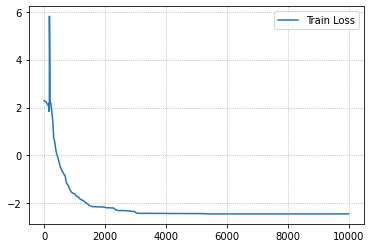

In [21]:
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1,n_epochs+1), np.log10(history), label="Train Loss")
plt.legend()

In [22]:
y_pred = my_network(t)

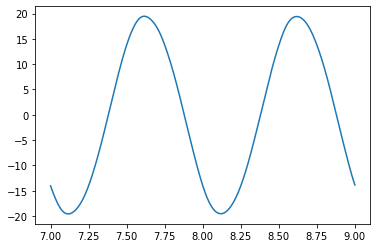

In [23]:
y_pred_plot = y_pred[:,0].detach().numpy()
plt.plot(t, y_pred_plot)

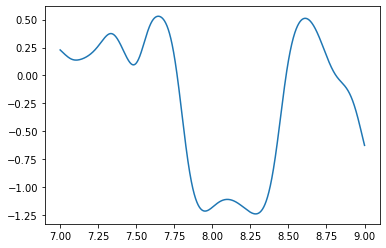

In [25]:
dy_pred_plot = y_pred[:,1].detach().numpy()
plt.plot(t, dy_pred_plot)

In [36]:
dy_pred = fd._differentiate(y_pred_plot, t)

In [27]:
y_pred_plot.shape

(10000,)

In [29]:
t = t.detach().numpy()

In [32]:
t = t.reshape(-1,)

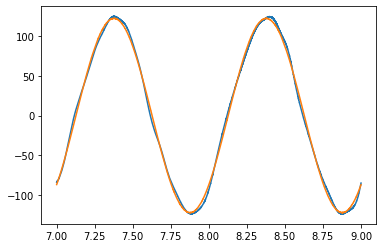

In [97]:
plt.plot(t,dy_pred)
plt.plot(t,dy)

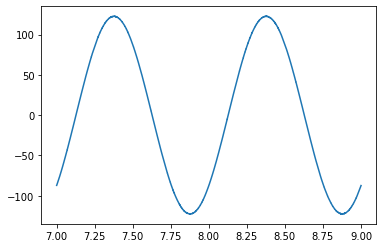

In [74]:
plt.plot(t,dy)

In [73]:
dy.shape

(10000,)

In [76]:
y = y.reshape(-1,1)
# Compute the relative L2 error norm (generalization error)
relative_error_test = np.mean((dy_pred - dy)**2)/np.mean(dy**2)
print("Relative Error Test: ", relative_error_test*100, "%")

Relative Error Test:  0.22853482262552824 %


In [83]:
from sklearn.metrics import mean_squared_error

In [84]:
mse = mean_squared_error(dy_pred, dy)

In [85]:
rmse = np.sqrt(mse)

In [86]:
diff = np.max(y)-np.min(y)

In [87]:
final = rmse/diff

In [88]:
final*100

10.531211066614114

In [89]:
t1 = dy_pred - dy

In [90]:
t2 = t1**2

array([ 7.74236782, 10.27351344, 10.63034217, ...,  2.32259652,
        3.40929097,  4.54246101])

17.13517232078767

In [94]:
t5 = np.sqrt(t4)

4.13946522159417

10.0